# French electricity load prediction 

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

## Construct data input

Target of this section is to extract data from hourly consumption and hourly meteo information. Result will be on single tab with :
* Consumption d
* Consumption d-1
* Consumption d-2
* Consumption d-3
* Consumption d-4
* Solar radiation
* wind speed
* temperature

Then this tab will be split for machin learning as *Consumption d* the output data to predict and other data as input.

### Consumption

In [5]:
consumption = pd.read_csv('resources/consommation-quotidienne-brute-regionale.csv', 
                          sep=';', 
                          parse_dates=[0])
consumption.drop(['Date', 'Heure', 'Code INSEE région', 'Statut - GRTgaz',\
                  'Consommation brute gaz (MW PCS 0°C) - GRTgaz', 'Statut - Teréga', \
                 'Consommation brute gaz (MW PCS 0°C) - Teréga', 'Statut - RTE'], 
                 axis=1, inplace=True)
consumption.columns = ['date', 'region', 'consumption (MWh)']
consumption.index = pd.to_datetime(consumption['date'], utc=True)
consumption = consumption.groupby(by=pd.Grouper(freq='D')).sum()
consumption.head()

consumption (MWh)
date                                        
2012-12-31 00:00:00+00:00            59662.0
2013-01-01 00:00:00+00:00          2615508.0
2013-01-02 00:00:00+00:00          3107212.0
2013-01-03 00:00:00+00:00          3196635.0
2013-01-04 00:00:00+00:00          3129474.0

### Wind and solar 

In [6]:
sw = pd.read_csv('resources/rayonnement-solaire-vitesse-vent-tri-horaires-regionaux.csv',
                 sep=';',
                 parse_dates=[0])
sw.drop(['Code INSEE région'], axis=1, inplace=True)
sw.columns = ['date', 'region', 'wind_speed (m/s)', 'solar_radiation (W/m2)']
sw.index = pd.to_datetime(sw['date'], utc=True)

In [7]:
solar = sw.drop('wind_speed (m/s)', axis=1)
solar = solar.groupby(by=pd.Grouper(freq='D')).mean()

In [8]:
wind = sw.drop('solar_radiation (W/m2)', axis=1)
wind = wind.groupby(by=pd.Grouper(freq='D')).mean()

### Temperature

In [9]:
temp = pd.read_csv('resources/temperature-quotidienne-regionale.csv', sep=';', parse_dates=[0])
temp.drop(['Code INSEE région', 'Région', 'TMin (°C)', 'TMax (°C)'], axis=1, inplace=True)
temp.columns = ['date', 'temperature (°C)']
temp.index = pd.to_datetime(temp['date'], utc=True)
temp = temp.groupby(by=pd.Grouper(freq='D')).mean()

### Merge 

In [10]:
data = pd.merge(consumption, solar, how='inner', left_index=True, right_index=True)
data = pd.merge(data, wind, how='inner', left_index=True, right_index=True)
data = pd.merge(data, temp, how='inner', left_index=True, right_index=True)

In [11]:
data['month'] = data.index.month
data['day_week'] = data.index.dayofweek

### Prepare data

In [12]:
c = data['consumption (MWh)']
data.drop(pd.date_range(start='2016-01-01 00:00:00+00:00', freq='D', periods=4), inplace=True)
data['consumption d-1'] = c[3:-1].values
data['consumption d-2'] = c[2:-2].values
data['consumption d-3'] = c[1:-3].values
data['consumption d-4'] = c[0:-4].values

In [13]:
data.head(10)

consumption (MWh)  solar_radiation (W/m2)  \
date                                                                   
2016-01-05 00:00:00+00:00          3234575.0               43.612885   
2016-01-06 00:00:00+00:00          3268121.0               39.137500   
2016-01-07 00:00:00+00:00          3251392.0               31.206250   
2016-01-08 00:00:00+00:00          3205301.0               45.046346   
2016-01-09 00:00:00+00:00          2849667.0               37.963077   
2016-01-10 00:00:00+00:00          2784139.0               38.943942   
2016-01-11 00:00:00+00:00          3195995.0               44.494519   
2016-01-12 00:00:00+00:00          3331976.0               55.128365   
2016-01-13 00:00:00+00:00          3442324.0               61.412788   
2016-01-14 00:00:00+00:00          3487782.0               40.836731   

                           wind_speed (m/s)  temperature (°C)  month  \
date                                                                   
2016-01-05 00:00:00+00:00          7.985962          7.699231      1   
2016-01-06 00:00:00+00:00          7.726442          7.582308      1   
2016-01-07 00:00:00+00:00          7.784327          8.716154      1   
2016-01-08 00:00:00+00:00          8.117500          7.598462      1   
2016-01-09 00:00:00+00:00          8.419135          8.879231      1   
2016-01-10 00:00:00+00:00          8.855096          8.314615      1   
2016-01-11 00:00:00+00:00          8.894231          8.326154      1   
2016-01-12 00:00:00+00:00          8.659615          7.404615      1   
2016-01-13 00:00:00+00:00          7.804231          5.490000      1   
2016-01-14 00:00:00+00:00          7.031635          5.099231      1   

                           day_week  consumption d-1  consumption d-2  \
date                                                                    
2016-01-05 00:00:00+00:00         1        3101717.0        2725674.0   
2016-01-06 00:00:00+00:00         2        3234575.0        3101717.0   
2016-01-07 00:00:00+00:00         3        3268121.0        3234575.0   
2016-01-08 00:00:00+00:00         4        3251392.0        3268121.0   
2016-01-09 00:00:00+00:00         5        3205301.0        3251392.0   
2016-01-10 00:00:00+00:00         6        2849667.0        3205301.0   
2016-01-11 00:00:00+00:00         0        2784139.0        2849667.0   
2016-01-12 00:00:00+00:00         1        3195995.0        2784139.0   
2016-01-13 00:00:00+00:00         2        3331976.0        3195995.0   
2016-01-14 00:00:00+00:00         3        3442324.0        3331976.0   

                           consumption d-3  consumption d-4  
date                                                         
2016-01-05 00:00:00+00:00        2668997.0        2575676.0  
2016-01-06 00:00:00+00:00        2725674.0        2668997.0  
2016-01-07 00:00:00+00:00        3101717.0        2725674.0  
2016-01-08 00:00:00+00:00        3234575.0        3101717.0  
2016-01-09 00:00:00+00:00        3268121.0        3234575.0  
2016-01-10 00:00:00+00:00        3251392.0        3268121.0  
2016-01-11 00:00:00+00:00        3205301.0        3251392.0  
2016-01-12 00:00:00+00:00        2849667.0        3205301.0  
2016-01-13 00:00:00+00:00        2784139.0        2849667.0  
2016-01-14 00:00:00+00:00        3195995.0        2784139.0

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_scaller = StandardScaler()
y_scaller = StandardScaler()

X = X_scaller.fit_transform(data.drop(['consumption (MWh)'], axis=1).values)
y = y_scaller.fit_transform(data['consumption (MWh)'].values.reshape(-1, 1)).ravel() # Reshape for scaller

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=456)

## Analyze different ML

We will test some differents algorithms with differents parameters

In [15]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

### Support machine regression

In [16]:
from sklearn.svm import SVR

In [17]:
params = {'C': [1, 5, 10, 15, 20, 25, 35, 45, 60]}
svr = GridSearchCV(SVR(gamma='auto'), params, cv=5, n_jobs=8)
svr.fit(X_train, y_train)
y_svr = svr.predict(X_test)
error_svr = np.abs(y_svr - y_test) / y_test

### Random forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
params = {'n_estimators': np.arange(100, 600, 100),
          'criterion': ['mse'],
          'max_depth': np.arange(2, 20)}
forest = GridSearchCV(RandomForestRegressor(), params, cv=5, n_jobs=8)
forest.fit(X_train, y_train)
y_forest = forest.predict(X_test)
error_forest = np.abs(y_forest - y_test) / y_test

### Polynomial regression

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [21]:
params ={'poly__degree': [1, 2, 3, 4, 5, 6]}
pipe = Pipeline([('poly', PolynomialFeatures()),('linear', LinearRegression(fit_intercept=False))])
poly = GridSearchCV(pipe, params, cv=5, n_jobs=8)
poly.fit(X_train, y_train)
poly.score(X_test, y_test)
y_poly = poly.predict(X_test)
error_poly = np.abs(y_poly - y_test) / y_test

/home/jolainfra/perso/machin-learning-course/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### KNN Regression

In [22]:
from sklearn.neighbors import KNeighborsRegressor

In [23]:
params = {'n_neighbors': np.arange(1, 15)}
knn = GridSearchCV(KNeighborsRegressor(), params, cv=5, n_jobs=8)
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
error_knn = np.abs(y_knn - y_test) / y_test

## Aggregate best result

In [24]:
error = [e.mean() for e in [error_svr, error_forest, error_poly, error_knn]]
w = np.array([int(e * 100 / np.sum(error)) for e in error])

In [25]:
y = np.array([y_svr, y_forest, y_poly, y_knn])
y_agg = w.dot(y) / 100
error_agg = np.abs(y_agg - y_test) / y_test

In [26]:
def split_resize(y, split):
    return y_scaller.inverse_transform(y[:split])

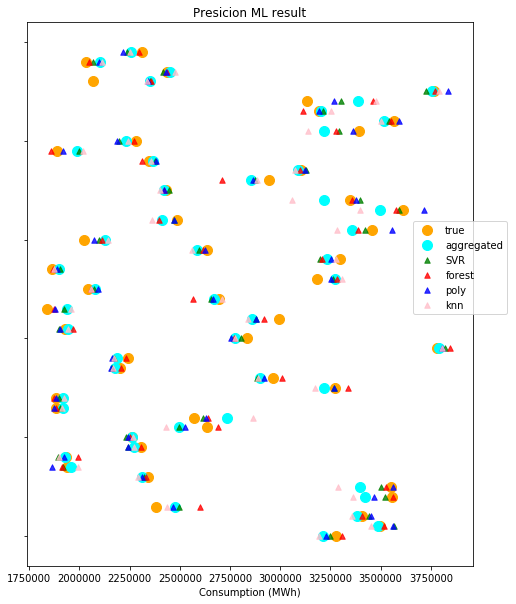

In [27]:
split = 50
t = np.arange(50)
fig, ax = plt.subplots(figsize=(8, 10))
ax.scatter(split_resize(y_test, split),   t, c='orange', marker='o', s=100, alpha=1,   label='true')
ax.scatter(split_resize(y_agg, split),    t, c='cyan',   marker='o', s=100, alpha=1,   label='aggregated')
ax.scatter(split_resize(y_svr, split),    t, c='green',  marker='^', s=30,  alpha=0.8, label='SVR')
ax.scatter(split_resize(y_forest, split), t, c='red',    marker='^', s=30,  alpha=0.8, label='forest')
ax.scatter(split_resize(y_poly, split),   t, c='blue',   marker='^', s=30,  alpha=0.8, label='poly')
ax.scatter(split_resize(y_knn, split),    t, c='pink',   marker='^', s=30,  alpha=0.8, label='knn')
ax.set_yticklabels([])
ax.set_xlabel('Consumption (MWh)')
ax.set_title('Presicion ML result')
fig.legend(loc=(0.8, 0.48))
plt.show()

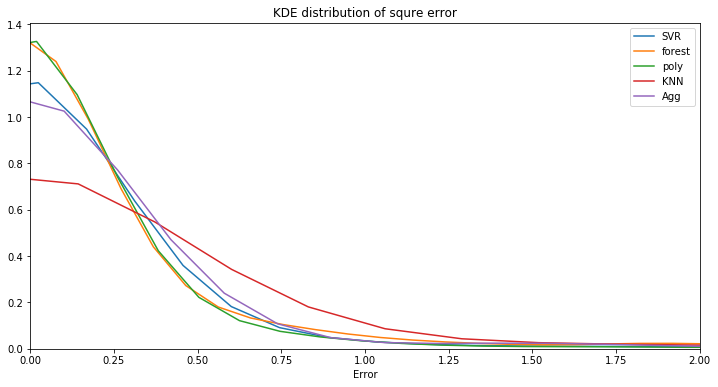

In [28]:
bins = 100
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(error_svr, ax=ax, label='SVR')
sns.kdeplot(error_forest, ax=ax, label='forest')
sns.kdeplot(error_poly, ax=ax, label='poly')
sns.kdeplot(error_knn, ax=ax, label='KNN')
sns.kdeplot(error_agg, ax=ax, label='Agg')
ax.set_xlim([0, 2])
ax.set_xlabel('Error')
#ax.set_yticks([])
ax.set_title('KDE distribution of squre error')
plt.show()